In [1]:
from time import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms, models, datasets
from torch.utils.data import DataLoader, Dataset, TensorDataset, random_split
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from faces import FaceData
from torchsummary import summary

%matplotlib inline
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('using device:', device)

using device: cuda


In [2]:
rootdir = 'F:\\facial\\P1_Facial_Keypoints'
train_ds = FaceData(rootdir)
test_ds = FaceData(rootdir, test=True)
test_ds, val_ds = random_split(test_ds, [len(test_ds)//2, len(test_ds) - len(test_ds)//2])

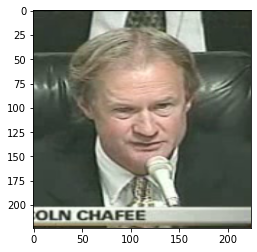

In [3]:
img, kp = train_ds[1]
plt.imshow(img.permute(1,2,0))

In [4]:
train_loader = DataLoader(train_ds, shuffle=True, batch_size=8)
test_loader = DataLoader(test_ds, shuffle=False, batch_size=1)
val_loader = DataLoader(val_ds, shuffle=False, batch_size=1)

In [5]:
# prepare model
model = models.vgg16_bn(pretrained=True)
# for param in model.parameters():
#     param.requires_grad = False

model.avgpool = nn.Sequential(
    nn.Conv2d(512, 512, 3),
    nn.MaxPool2d(2),
    nn.Flatten()
)

model.classifier = nn.Sequential(
    nn.Linear(2048, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 136),
    nn.Sigmoid()
)

# loss fn
lossfn = nn.L1Loss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3)
model = model.to(device)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5,
    threshold=0.01, min_lr=1e-6, verbose=True, factor=0.2)

In [6]:
summary(model, torch.zeros(1, 3, 224, 224, device=device))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 7, 7]           --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        1,792
|    └─BatchNorm2d: 2-2                  [-1, 64, 224, 224]        128
|    └─ReLU: 2-3                         [-1, 64, 224, 224]        --
|    └─Conv2d: 2-4                       [-1, 64, 224, 224]        36,928
|    └─BatchNorm2d: 2-5                  [-1, 64, 224, 224]        128
|    └─ReLU: 2-6                         [-1, 64, 224, 224]        --
|    └─MaxPool2d: 2-7                    [-1, 64, 112, 112]        --
|    └─Conv2d: 2-8                       [-1, 128, 112, 112]       73,856
|    └─BatchNorm2d: 2-9                  [-1, 128, 112, 112]       256
|    └─ReLU: 2-10                        [-1, 128, 112, 112]       --
|    └─Conv2d: 2-11                      [-1, 128, 112, 112]       147,584
|    └─BatchNorm2d: 2-12                 [-1, 128, 112, 112]      

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 7, 7]           --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        1,792
|    └─BatchNorm2d: 2-2                  [-1, 64, 224, 224]        128
|    └─ReLU: 2-3                         [-1, 64, 224, 224]        --
|    └─Conv2d: 2-4                       [-1, 64, 224, 224]        36,928
|    └─BatchNorm2d: 2-5                  [-1, 64, 224, 224]        128
|    └─ReLU: 2-6                         [-1, 64, 224, 224]        --
|    └─MaxPool2d: 2-7                    [-1, 64, 112, 112]        --
|    └─Conv2d: 2-8                       [-1, 128, 112, 112]       73,856
|    └─BatchNorm2d: 2-9                  [-1, 128, 112, 112]       256
|    └─ReLU: 2-10                        [-1, 128, 112, 112]       --
|    └─Conv2d: 2-11                      [-1, 128, 112, 112]       147,584
|    └─BatchNorm2d: 2-12                 [-1, 128, 112, 112]      

In [7]:
def train_batch(xs, ys, model, lossfn, opter):
    model.train()
    opter.zero_grad()
    yps = model(xs)
    loss = lossfn(yps, ys)
    loss.backward()
    opter.step()

    return loss.item()

@torch.no_grad()
def validate_batch(xs, ys, model, lossfn):
    model.eval()
    yps = model(xs)
    loss = lossfn(yps, ys)
    return loss.item()

In [8]:
train_loss = []
val_loss = []

for epoch in range(50):
    start = time()
    epoch_train_loss = 0
    epoch_train_steps = 0
    epoch_val_loss = 0
    epoch_val_steps = 0

    for xs, ys in train_loader:
        xs = xs.to(device)
        ys = ys.to(device)
        loss = train_batch(xs, ys, model, lossfn, optimizer)
        epoch_train_loss += loss
        epoch_train_steps += 1
    epoch_train_loss /= epoch_train_steps

    for xs, ys in val_loader:
        xs = xs.to(device)
        ys = ys.to(device)
        loss = validate_batch(xs, ys, model, lossfn)
        epoch_val_loss += loss
        epoch_val_steps += 1
    epoch_val_loss /= epoch_val_steps
    lr_scheduler.step((epoch_val_loss + epoch_train_loss)/2)

    train_loss.append(epoch_train_loss)
    val_loss.append(epoch_val_loss)

    print('epoch %d: consume %.0fs, train_loss: %.4f, val_loss:%.4f' %
          (epoch, time()-start, epoch_train_loss, epoch_val_loss))

test_loss = 0.0
test_steps = 0
for xs, ys in test_loader:
    xs = xs.to(device)
    ys = ys.to(device)
    loss = validate_batch(xs, ys, model, lossfn)
    test_loss += loss
    test_steps += 1
test_loss /= test_steps
print("final test loss: %.4f" % test_loss)

RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 3.00 GiB total capacity; 2.16 GiB already allocated; 6.53 MiB free; 2.17 GiB reserved in total by PyTorch)

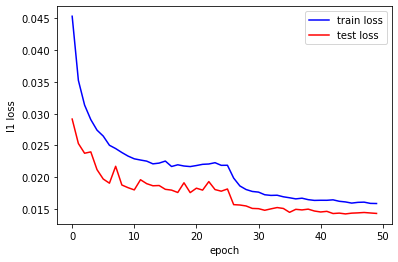

In [ ]:
plt.plot(train_loss, 'b', label='train loss')
plt.plot(val_loss, 'r', label='test loss')
plt.xlabel('epoch')
plt.ylabel('l1 loss')
plt.legend()
plt.show()

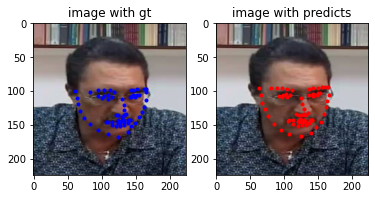

In [ ]:
img, kp = test_ds[5]
plt.subplot(1, 2, 1)
plt.title('image with gt')
plt.imshow(img.permute(1, 2, 0))
plt.scatter(kp[:68]*224, kp[68:]*224, c='b', marker='.')
model.eval()
pkp = model(img.to(device).unsqueeze(0)).squeeze(0).detach().cpu()
plt.subplot(1, 2, 2)
plt.title('image with predicts')
plt.imshow(img.permute(1, 2, 0))
plt.scatter(pkp[:68]*224, pkp[68:]*224, c='r', marker='.')
plt.grid(False)
plt.show()